# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions:

### Our IDs
209209691
315856484
---
---


In [32]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.datasets import load_digits


np.random.seed(42)

# Part 1: Design the Algorithm

## Design of t-SNE

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a non-linear dimensionality reduction technique designed to visualize high-dimensional data in a lower-dimensional space, typically 2D or 3D. It focuses on preserving the local structure of the data by modeling pairwise similarities between points in both the high-dimensional and low-dimensional spaces.

## Algorithm Description

### Step 1: Compute Pairwise Distances
•⁠  ⁠Use Euclidean distance to compute for all \( i, j \):

$$
 D_{ij} = \|x_i - x_j\|^2
$$


### Step 2: Compute High-Dimensional Probabilities \( P_{ij} \)

For each point \( i \):  
1. Perform binary search to find the Gaussian variance \( \sigma_i \) such that the perplexity of the distribution matches the target value. Perplexity is defined as:  

   $$
   \text{Perplexity}(P_{i}) = 2^{-\sum_j P_{j|i} \log_2 P_{j|i}}
   $$

2. Compute conditional probabilities:

   $$
   P_{j|i} = \frac{\exp\left(-\frac{\|x_i - x_j\|^2}{2\sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(-\frac{\|x_i - x_k\|^2}{2\sigma_i^2}\right)}
   $$

3. Symmetrize and normalize \( P \):

   $$
   P_{ij} = \frac{P_{j|i} + P_{i|j}}{2n}, \quad \sum_{i \neq j} P_{ij} = 1
   $$


### Step 3: Initialize Low-Dimensional Embedding \( Y \)
•⁠  ⁠Randomly initialize \( Y \) using a Gaussian distribution centered at 0.

### Step 4: Compute Low-Dimensional Probabilities \( Q_{ij} \)
•⁠  ⁠Compute pairwise distances in the low-dimensional space:

 $$
 Q_{ij} = \frac{1}{1 + \|y_i - y_j\|^2}
 $$

•⁠  ⁠Normalize:

$$
  Q_{ij} = \frac{Q_{ij}}{\sum_{k \neq l} Q_{kl}}
 $$


### Step 5: Compute Gradient and Optimize
•⁠  ⁠Compute gradient of the KL divergence:
   $$
  \frac{\partial C}{\partial y_i} = 4 \sum_{j \neq i} \left( (P_{ij} - Q_{ij}) Q_{ij} \cdot (y_i - y_j) \right)
  $$
•⁠  ⁠Update \( Y \) using gradient descent with momentum:
  $$
  dY_t = \eta \frac{\partial C}{\partial Y} + \alpha dY_{t-1}
   $$
   $$
  Y_{t+1} = Y_t - dY_t
   $$


### Step 6: Output
•⁠  ⁠Return \( Y \) as the low-dimensional representation.

---

## Hyperparameters

1.⁠ ⁠*Perplexity* (\( p \)):
   - Affects the number of effective neighbors for each point.
   - standard range: 5 - 50.

2.⁠ ⁠*Number of Iterations* ( n_iter ):
   - Defines the number of optimization steps.
   - Typical value: 1000.

3.⁠ ⁠*Learning Rate* ( eta ) :
   - Determines the step size for gradient updates.
   - Default: 200.0.

4.⁠ ⁠*Momentum* ( alpha ):
   - Smoothens updates and prevents oscillations.
   - Default: 0.5.

5.⁠ ⁠*Dimensionality* ( k ):
   - Output dimensionality, typically 2 or 3 (we are using 2).

---

## Optimization Strategy

1.⁠ ⁠*Gradient Descent with Momentum*:
   - Momentum is applied to smooth the gradient updates and escape local minima. This helps accelerate convergence and improve the overall quality of the embedding.

2.⁠ ⁠*Symmetric t-SNE*:
   - Symmetric t-SNE is used to average the affinities between pairs of points, providing a more stable and reliable embedding. This symmetry improves the quality of the low-dimensional representation.

3.⁠ ⁠*Early Compression*:
   - Regularization is applied early in the optimization process to prevent premature clustering. This ensures that the low-dimensional embedding does not overly compress the data too early, allowing for a more distinct and meaningful separation of clusters.

4.⁠ ⁠*Early Exaggeration*:
   - Probabilities are amplified during the initial stages of optimization to emphasize local structure and help form distinct clusters. As the algorithm progresses, the exaggeration factor is gradually reduced to allow the model to focus more on global relationships.

---

## Theoretical and Practical Considerations

### Theoretical Considerations
•⁠  ⁠*Similarity Metrics*: High-dimensional similarities use Gaussian distributions, while low-dimensional similarities use a heavy-tailed t-distribution to better capture local relationships (different from regular SNE).
•⁠  ⁠*KL Divergence*: Optimizing this non-convex objective can lead to local minima.
•⁠  ⁠*Perplexity*: Controls the effective number of neighbors for each data point, balancing global and local structure preservation.

### Practical Considerations
•⁠  ⁠*Scalability*: Computing pairwise distances for large datasets is computationally expensive (\( O(n^2) \)).
•⁠  ⁠*Optimization Stability*: Requires careful tuning of learning rate and momentum to avoid divergence or slow convergence.

### Limitations
•⁠  ⁠Not suitable for very large datasets without approximation techniques (e.g., Barnes-Hut or FFT-based methods).
•⁠  ⁠Sensitive to hyperparameters like perplexity and learning rate, which require domain knowledge for optimal tuning.
•⁠  ⁠May distort global structures to prioritize local ones.
•⁠  ⁠Cannot be reused on new datasets like PCA.

### Use-Cases
•⁠  ⁠*Visualization*: Reducing high-dimensional data to 2D - 3D for intuitive visualization.
•⁠  ⁠*Clustering*: Identifying clusters in data based on the low-dimensional embedding.
•⁠  ⁠*Anomaly Detection*: Highlighting outliers that differ significantly from the data's local structure.
-  *Feature Evaluation*: Assess feature separability in high-dimensional spaces.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

### Design Considerations and Algorithmic Choices

#### 1. `BinarySearch` Class for Perplexity Calculation
- **Purpose:** The `BinarySearch` class is designed to optimize the sigma (scale parameter) for each data point to match the target perplexity. The perplexity is crucial in t-SNE as it controls the neighborhood size for each point. The class implements binary search to iteratively adjust the value of sigma until the perplexity converges to the target value.
- **Algorithm:**
  - We start with a very large range for sigma (`sigma_min` and `sigma_max`).
  - For each iteration, the perplexity is computed for a chosen sigma. If the perplexity is higher than the target, we adjust the upper bound (`sigma_max`), and if it is lower, we adjust the lower bound (`sigma_min`).
  - The binary search stops when the difference between the calculated perplexity and the target is smaller than the tolerance (`tol`) or the maximum number of iterations (`max_iter`) is reached.

#### 2. `CustomTSNE` Class for t-SNE Algorithm
The main class `CustomTSNE` implements the t-SNE algorithm with several core components:

- **`__init__` Method:**
  - Accepts several hyperparameters for t-SNE, as we described above.
  - Initializes attributes for random state, momentum for gradient updates, and other parameters like `previous_dY` (to store previous gradients for momentum) and `kl_history` (to track KL divergence over iterations).

- **`_compute_pairwise_distances` Method:**
  - This helper function calculates the pairwise Euclidean squared distances between all data points in X, which is essential for both computing joint probabilities and t-SNE's gradient.

- **`_compute_joint_probabilities` Method:**
  - For each data point, this method calculates its conditional probabilities (based on distances) using the `BinarySearch` class to tune the scale parameter (sigma).
  - Joint probabilities are symmetrized to ensure the probabilities are mutual between points.
  - The matrix `P` is then normalized and stabilized to avoid computational issues.

- **`_compute_q_distribution` Method:**
  - Computes the distribution `Q` in the low-dimensional space using the Student t-distribution. This distribution is used to model the probability of pairwise similarities in the embedded space. As we studied in the lecture, it is better to use this distributed then the normal one.
  - The distances in the low-dimensional space are transformed into similarities using `1 / (1 + distances)`.

- **`_gradient` Method:**
  - This function computes the gradient of the KL divergence between the high-dimensional joint probability distribution `P` and the low-dimensional distribution `Q`.
  - The gradient is based on the difference between `P` and `Q` and is scaled by the inverse distances to maintain a balance between local and global relationships.

- **`fit_transform` Method:**
  - This is the core method where the t-SNE optimization happens. It initializes the low-dimensional representation of the data (`Y`), computes pairwise distances and joint probabilities, and iteratively updates the low-dimensional representation using gradient descent.
  - In each iteration, we compute `Q` and its corresponding gradient, update the points (`Y`), apply momentum, and adjust using the learning rate.
  - KL divergence is tracked during the iterations, and the algorithm stops when convergence criteria are met.

- **`transform` Method:**
  - This method allows new data points to be projected into the existing t-SNE embedding. It works by first calculating the joint probabilities for the new data points and then using gradient descent to embed them into the low-dimensional space.

- **KL Divergence Plotting:**
  - The method `plot_kl_divergence` generates a plot of the KL divergence history over iterations. This helps in diagnosing the convergence of the algorithm.

---

### Design and Algorithmic Considerations

1. **Binary Search for Perplexity:**
   - Using binary search allows for a more efficient way to find the optimal `sigma` that matches the target perplexity compared to trying all possible values. The binary search ensures that the process is logarithmic in terms of the number of iterations - faster convergence.

2. **Gradient Descent with Momentum:**
   - Gradient descent to minimize the KL divergence. To stabilize and accelerate convergence, momentum is used to accumulate the previous gradient (`dY`). This helps smooth out oscillations and enables faster convergence.

3. **Numerical Stability:**
   - Numerical stability is ensured by applying a small constant (`1e-12`) when normalizing probabilities and in logarithmic computations. This prevents issues that may arise from taking logarithms of very small numbers or dividing by small values (go to infinity).

---

### Testing and Evaluation

To evaluate the implementation, we will test it on real datasets and compare the results with the standard sklearn t-sne implementation.

Some key performance metrics to look for include:
- **Convergence behavior**: Ensure that KL divergence decreases over iterations and that the algorithm converges within the expected number of iterations.
- **Quality of Embedding**: Visualize the output in 2D or 3D using scatter plots and check whether similar points are mapped close to each other.

---

In [33]:
#Helper functions
class BinarySearch:
    """Helper class for binary search to find optimal sigma values."""
    def __init__(self, target_perplexity, tol=1e-5, max_iter=50):
        self.target_perplexity = target_perplexity
        self.max_iter = max_iter
        self.tol = tol

    def _compute_perplexity(self, distances, sigma):
        """Compute perplexity for given sigma value."""
        exp_distances = np.exp(-distances / (2 * sigma * sigma))
        exp_distances = exp_distances / np.sum(exp_distances)
        entropy = -np.sum(exp_distances * np.log2(exp_distances + 1e-12))
        perplexity = 2 ** entropy
        return perplexity, exp_distances

    def find_sigma(self, distances):
        """Find optimal sigma using binary search."""
        sigma_min = 1e-20
        sigma_max = 1e20
        sigma = 1.0

        for i in range(self.max_iter):
            perplexity, exp_distances = self._compute_perplexity(distances, sigma)

            if abs(perplexity - self.target_perplexity) < self.tol:
                break

            if perplexity > self.target_perplexity:
                sigma_max = sigma
                sigma = (sigma_min + sigma_max) / 2
            else:
                sigma_min = sigma
                sigma = (sigma_min + sigma_max) / 2

        return exp_distances

In [34]:
class CustomTSNE:
    def __init__(self, perplexity=50.0, n_components=2, n_iter=1000, learning_rate=200.0, momentum=0.5):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.random_state = np.random.RandomState(42)
        self.previous_dY = None
        self.kl_history = []


    def _compute_pairwise_distances(self, X):
        """Compute pairwise distances between points in X."""
        return pairwise_distances(X, metric='euclidean', squared=True)

    def _compute_joint_probabilities(self, distances, perplexity, tol=1e-5):
        """Convert distances to joint probabilities P_ij."""
        n_samples = distances.shape[0]
        P = np.zeros((n_samples, n_samples))

        # Set target perplexity using binary search
        for i in range(n_samples):
            binary_search = BinarySearch(perplexity, tol)
            dist_i = distances[i, np.concatenate((np.r_[0:i], np.r_[i+1:n_samples]))]
            P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n_samples]))] = binary_search.find_sigma(dist_i)

        # Symmetrize P and normalize
        P = (P + P.T) / (2 * n_samples)
        P = np.maximum(P, 1e-12)  # Numerical stability
        return P

    def _compute_q_distribution(self, Y):
        """Compute the Student t-distribution Q_ij in the low-dimensional space."""
        distances = self._compute_pairwise_distances(Y)
        inv_distances = 1 / (1 + distances)
        np.fill_diagonal(inv_distances, 0)

        # Normalize Q distribution
        Q = inv_distances / np.sum(inv_distances)
        Q = np.maximum(Q, 1e-12)
        return Q, inv_distances

    def _gradient(self, P, Q, Y, inv_distances):
        """Compute the gradient of the KL divergence."""
        n_samples = Y.shape[0]
        dY = np.zeros((n_samples, self.n_components))

        # Compute gradient according to the formula
        for i in range(n_samples):
            diff = Y[i] - Y
            dist_factors = (P[i] - Q[i]) * inv_distances[i]
            dY[i] = 4 * np.sum(diff * dist_factors.reshape(-1, 1), axis=0)

        return dY

    def plot_kl_divergence(self):
        """Plot the KL divergence over iterations."""
        plt.figure(figsize=(8, 5))
        plt.plot(self.kl_history)
        plt.xlabel("Iteration")
        plt.ylabel("KL Divergence")
        plt.title("KL Divergence Over Iterations")
        plt.grid()
        plt.show()

    def fit_transform(self, X):
        """Main method to fit t-SNE and transform the data."""
        n_samples = X.shape[0]

        # Initialize low-dimensional representation
        Y = self.random_state.normal(0, 1e-4, size=(n_samples, self.n_components))

        # Compute pairwise affinities
        distances = self._compute_pairwise_distances(X)
        P = self._compute_joint_probabilities(distances, self.perplexity)

        # Gradient descent
        for iteration in range(self.n_iter):
            # Compute Q distribution and inverse distances
            Q, inv_distances = self._compute_q_distribution(Y)

            # Compute gradient
            dY = self._gradient(P, Q, Y, inv_distances)

             # Momentum update
            if self.previous_dY is not None:
                dY += self.momentum * self.previous_dY
            self.previous_dY = dY

            # Update Y with momentum and learning rate
            Y = Y - self.learning_rate * dY

            # Zero-center the points
            Y = Y - np.mean(Y, axis=0)

            C = np.sum(P * np.log(P / Q))

            self.kl_history.append(C)

        return Y


    def transform(self, X_original, Y_original, X_new):
        """Transform new points into the existing t-SNE embedding."""
        n_original = X_original.shape[0]
        n_new = X_new.shape[0]

        # Compute pairwise distances between new and original points
        distances_new = pairwise_distances(X_new, X_original, metric='euclidean', squared=True)

        # Initialize new points randomly near the center of the embedding
        Y_new = self.random_state.normal(0, 1e-4, size=(n_new, self.n_components))

        # Compute joint probabilities for new points
        P_new = np.zeros((n_new, n_original))
        for i in range(n_new):
            binary_search = BinarySearch(self.perplexity, 1e-5)
            P_new[i] = binary_search.find_sigma(distances_new[i])

        # Normalize P_new
        P_new = P_new / np.sum(P_new)

        # Gradient descent for new points
        for iteration in range(self.n_iter):
            # Compute Q distribution for new points
            distances_embedded = pairwise_distances(Y_new, Y_original, metric='euclidean', squared=True)
            Q_new = 1 / (1 + distances_embedded)
            Q_new = Q_new / np.sum(Q_new)

            # Compute gradient for new points
            dY_new = np.zeros_like(Y_new)
            for i in range(n_new):
                diff = Y_new[i] - Y_original
                factors = (P_new[i] - Q_new[i]) / (1 + distances_embedded[i])
                dY_new[i] = 4 * np.sum(diff * factors.reshape(-1, 1), axis=0)

            # Update positions
            Y_new = Y_new - self.learning_rate * dY_new

        return Y_new

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

Dataset Choice for t-SNE
The dataset used in this implementation is the digits dataset from sklearn.datasets. This dataset consists of 8x8 grayscale images of handwritten digits (0-9), with 64 features (pixel intensities) representing each image and corresponding labels for the digits.

Why This Dataset Is Appropriate for t-SNE:

High Dimensionality:
This data set contains digits represented in a 64-dimensional feature space, making it a good choice for dimensionality reduction techniques like t-SNE, which excel at visualizing high-dimensional data in 2D in our case.


Natural Clustering: The digits dataset has inherent clusters (based on digit labels), which makes it an excellent candidate for t-SNE. The algorithm can effectively separate these clusters in lower dimensions, providing insightful visualizations of the data's structure.

In [35]:
# Load digits dataset
data = load_digits()

# Extract features and labels
X = data.data
y = data.target

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


# t-SNE demonstration
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

# t-SNE Analysis and Results

## Hyperparameters
This section of code systematically evaluates the impact of three hyperparameters—number of iterations, perplexity, and learning rate—on the performance of our custom t-SNE implementation. It may take a long time (approx 12 - 15m to run)

### 1.1 Number of Iterations
- **Purpose**: Controls the number of iteration the gradient descent do. More iterations allow better approximation of the desired distribution, reducing KL divergence, but take larger time.
- **Values Checked**: `600`, `800`, `1000`, `1200`
- **Results**:
  - Lower iterations (`600`, `800`): higher KL divergence, less distinct clusters.
  - `1000`: Balanced runtime and cluster separation with clear digit clusters.
  - `1200`: Small improvement in KL divergence but, not 'worth' the extra calculation time.
- **Best Value**: `1000`



### 1.2 Perplexity
- **Purpose**: Balances local and global structure preservation by determining the number of nearest neighbors considered.
- **Values Checked**: `5`, `15`, `30`, `50`
- **Results**:
  - `5`, `15`: Not good results as it emphasized local clusters but got noise in global arrangement.
  - `30`: Balanced local and global structure well.
  - `50`: Stable global structures but reduced local clustering detail.
- **Best Value**: `30`



### 1.3 Learning Rate
- **Purpose**: Determines the gradient descent step size. A small rate leads to slow convergence, while a large rate risks overshooting.
- **Values Checked**: `50`, `200`, `300`, `500`
- **Results**:
  - `50`: Slow convergence, noisy results.
  - `200`: Balanced speed and cluster quality.
  - `300`: Balanced speed and better cluster quality.
  - `500`: Faster convergence but some instability and cluster overlap.
- **Best Value**: `300`



## Part 2: Best Results with Optimal Parameters
- **Optimal Parameters**:
  - Iterations: `1000`
  - Perplexity: `50`
  - Learning Rate: `300`
- **Results**:
  - **Visualization**:
    - Clusters are distinct and well-separated with minimal overlap.
  - **KL Divergence**:
    - Low KL divergence, indicating good approximation of high-dimensional data.
    - Smooth convergence demonstrated in the KL divergence plot.


In [ ]:
perplexities = [5, 15, 30, 50]

# Compare perplexities for custom t-SNE
fig, axes = plt.subplots(2, len(perplexities), figsize=(15, 8))
for i, perplexity in enumerate(perplexities):
    custom_tsne = CustomTSNE(n_components=2, perplexity=perplexity)
    custom_Y = custom_tsne.fit_transform(X_train)

    # Scatter plot
    sc = axes[0, i].scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
    axes[0, i].set_title(f'Perplexity = {perplexity}')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    # Set title with highlighting for selected perplexity
    best_perplexity = 50
    if perplexity == best_perplexity:
        axes[0, i].set_title(f'Perplexity = {perplexity}', fontsize=14, color='green', fontweight='bold')
    else:
        axes[0, i].set_title(f'Perplexity = {perplexity}', fontsize=10)

    # Add colorbar to scatter plot
    colorbar = fig.colorbar(sc, ax=axes[0, i], orientation='vertical')
    colorbar.set_label('Class')

    # KL divergence plot
    axes[1, i].plot(custom_tsne.kl_history)
    axes[1, i].set_title('KL Divergence')
    axes[1, i].set_xlabel('Iteration')
    axes[1, i].set_ylabel('KL')

     # KL divergence plot
    kl_min = min(custom_tsne.kl_history)  # Minimum KL divergence
    axes[1, i].plot(custom_tsne.kl_history)
    axes[1, i].set_title('KL Divergence')
    axes[1, i].set_xlabel('Iteration')
    axes[1, i].set_ylabel('KL')

    # Annotate minimum KL divergence
    axes[1, i].annotate(f'Min KL: {kl_min:.4f}',
                        xy=(len(custom_tsne.kl_history) - 1, kl_min),
                        xytext=(-50, 10),
                        textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10,
                        color='red')

plt.tight_layout()
plt.show()


n_iter = [600, 800, 1000, 1200]

# Compare iterations for custom t-SNE
fig, axes = plt.subplots(2, len(n_iter), figsize=(15, 8))
for i, iterations in enumerate(n_iter):
    custom_tsne = CustomTSNE(n_components=2, perplexity=best_perplexity, n_iter=iterations)
    custom_Y = custom_tsne.fit_transform(X_train)

    # Scatter plot
    sc = axes[0, i].scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
    axes[0, i].set_title(f'Iterations = {iterations}')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    # Set title with highlighting for selected iteration
    best_n_iter = 1000
    if iterations == best_n_iter:
        axes[0, i].set_title(f'Iterations = {iterations}', fontsize=14, color='green', fontweight='bold')
    else:
        axes[0, i].set_title(f'Iterations = {iterations}', fontsize=10)

    # Add colorbar to scatter plot
    colorbar = fig.colorbar(sc, ax=axes[0, i], orientation='vertical')
    colorbar.set_label('Class')

    # KL divergence plot
    kl_min = min(custom_tsne.kl_history)  # Minimum KL divergence
    axes[1, i].plot(custom_tsne.kl_history)
    axes[1, i].set_title('KL Divergence')
    axes[1, i].set_xlabel('Iteration')
    axes[1, i].set_ylabel('KL')

    # Annotate minimum KL divergence
    axes[1, i].annotate(f'Min KL: {kl_min:.4f}',
                        xy=(len(custom_tsne.kl_history) - 1, kl_min),
                        xytext=(-50, 10),
                        textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10,
                        color='red')

plt.tight_layout()
plt.show()


learning_rates = [50, 200, 300, 500]

# Compare learning rates for custom t-SNE
fig, axes = plt.subplots(2, len(learning_rates), figsize=(15, 8))
for i, learning_rate in enumerate(learning_rates):
    custom_tsne = CustomTSNE(n_components=2,n_iter=best_n_iter, perplexity=best_perplexity, learning_rate=learning_rate)
    custom_Y = custom_tsne.fit_transform(X_train)

    # Scatter plot
    sc = axes[0, i].scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=y_train.astype(int), cmap='tab10')
    axes[0, i].set_title(f'Learning Rate = {learning_rate}')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    # Set title with highlighting for selected perplexity
    best_learning_rate = 300
    if learning_rate == best_learning_rate:
        axes[0, i].set_title(f'Learning Rate = {learning_rate}', fontsize=14, color='green', fontweight='bold')
    else:
        axes[0, i].set_title(f'Learning Rate = {learning_rate}', fontsize=10)

    # Add colorbar to scatter plot
    colorbar = fig.colorbar(sc, ax=axes[0, i], orientation='vertical')
    colorbar.set_label('Class')

    # KL divergence plot
    axes[1, i].plot(custom_tsne.kl_history)
    axes[1, i].set_title('KL Divergence')
    axes[1, i].set_xlabel('Iteration')
    axes[1, i].set_ylabel('KL')

     # KL divergence plot
    kl_min = min(custom_tsne.kl_history)  # Minimum KL divergence
    axes[1, i].plot(custom_tsne.kl_history)
    axes[1, i].set_title('KL Divergence')
    axes[1, i].set_xlabel('Iteration')
    axes[1, i].set_ylabel('KL')

    # Annotate minimum KL divergence
    axes[1, i].annotate(f'Min KL: {kl_min:.4f}',
                        xy=(len(custom_tsne.kl_history) - 1, kl_min),
                        xytext=(-50, 10),
                        textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red'),
                        fontsize=10,
                        color='red')

plt.tight_layout()
plt.show()


## Best parameters selected

In [ ]:
best_perplexity = 50
best_n_iter = 1000
best_learning_rate = 300

## Comparison Between Custom and Scikit-learn t-SNE

### Cluster Quality
- **Custom t-SNE**:
  - Clear clusters but with slightly higher intra-cluster distances.
  - Moderate inter-cluster separation with a separation ratio of `4.621`.
- **Scikit-learn t-SNE**:
  - Slightly better cluster separation with a higher inter-cluster distance (`34.094`) and separation ratio (`5.831`).
  - Larger intra-cluster distances (`5.903`).


### Performance and Robustness
- **Custom t-SNE**:
  - Execute Exact computations without advanced approximations like Barnes-Hut or FFT for large datasets.
  - Sensitive to hyperparameters.
- **Scikit-learn t-SNE**:
  - Leverages optimized implementations (Barnes-Hut or FIt-SNE).
  - Sklearn uses a smart method called Barnes-Hut t-SNE for 2D embeddings, which speeds up calculations by grouping points that are close   together. For higher dimensions, it uses another fast method based on FFT (Fast Fourier Transform) to handle the data efficiently. These tricks make sklearn's t-SNE much faster and able to work with large datasets.

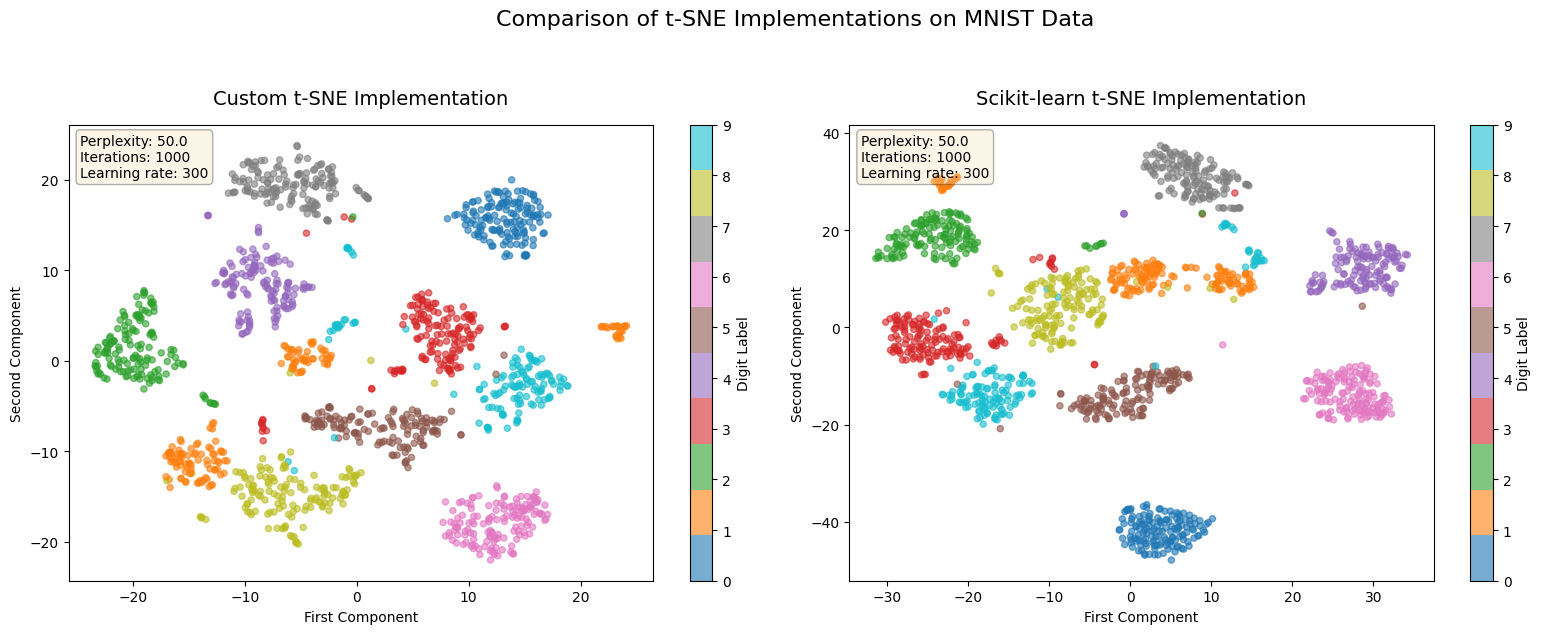


Cluster Separation Metrics:

Custom t-SNE:
Average intra-cluster distance: 4.621
Average inter-cluster distance: 21.412
Separation ratio (inter/intra): 4.634

Scikit-learn t-SNE:
Average intra-cluster distance: 6.152
Average inter-cluster distance: 35.564
Separation ratio (inter/intra): 5.781


In [ ]:
# Run our custom t-SNE implementation with best params
custom_tsne = CustomTSNE(n_components=2, perplexity=best_perplexity, n_iter=best_n_iter, learning_rate=best_learning_rate)
custom_Y = custom_tsne.fit_transform(X_train)

# Run sklearn t-SNE
sk_tsne = TSNE(n_components=2, init='random', perplexity=best_perplexity)
sk_Y = sk_tsne.fit_transform(X_train)

# Create visualization
plt.figure(figsize=(16, 6))

# Custom t-SNE plot
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(custom_Y[:, 0], custom_Y[:, 1],
                      c=y_train.astype(int),
                      cmap='tab10',
                      s=20,
                      alpha=0.6)
plt.colorbar(scatter1, label='Digit Label')
plt.title('Custom t-SNE Implementation', fontsize=14, pad=15)
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Add text box with parameters
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
plt.text(0.02, 0.98,
         f'Perplexity: {best_perplexity:.1f}\nIterations: {best_n_iter}\nLearning rate: {best_learning_rate}',
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=props)

# Scikit-learn t-SNE plot
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(sk_Y[:, 0], sk_Y[:, 1],
                      c=y_train.astype(int),
                      cmap='tab10',
                      s=20,
                      alpha=0.6)
plt.colorbar(scatter2, label='Digit Label')
plt.title('Scikit-learn t-SNE Implementation', fontsize=14, pad=15)
plt.xlabel('First Component')
plt.ylabel('Second Component')

# Add text box with parameters
plt.text(0.02, 0.98,
         f'Perplexity: {best_perplexity:.1f}\nIterations: {best_n_iter}\nLearning rate: {best_learning_rate}',
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=props)

# Adjust layout and add main title
plt.suptitle('Comparison of t-SNE Implementations on MNIST Data',
            fontsize=16,
            y=1.05)
plt.tight_layout()

# Show plot
plt.show()

# Calculate cluster separation metrics
def calculate_cluster_metrics(embeddings, labels):
    n_clusters = len(np.unique(labels))
    cluster_centers = np.array([embeddings[labels == i].mean(axis=0) for i in range(n_clusters)])

    # Calculate average intra-cluster distance
    intra_cluster_dist = np.mean([np.mean(np.linalg.norm(embeddings[labels == i] -
                                cluster_centers[i], axis=1)) for i in range(n_clusters)])

    # Calculate average inter-cluster distance
    inter_cluster_dists = []
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            dist = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
            inter_cluster_dists.append(dist)
    inter_cluster_dist = np.mean(inter_cluster_dists)

    return intra_cluster_dist, inter_cluster_dist

# Print clustering metrics
print("\nCluster Separation Metrics:")
custom_intra, custom_inter = calculate_cluster_metrics(custom_Y, y_train)
sk_intra, sk_inter = calculate_cluster_metrics(sk_Y, y_train)

print("\nCustom t-SNE:")
print(f"Average intra-cluster distance: {custom_intra:.3f}")
print(f"Average inter-cluster distance: {custom_inter:.3f}")
print(f"Separation ratio (inter/intra): {custom_inter/custom_intra:.3f}")

print("\nScikit-learn t-SNE:")
print(f"Average intra-cluster distance: {sk_intra:.3f}")
print(f"Average inter-cluster distance: {sk_inter:.3f}")
print(f"Separation ratio (inter/intra): {sk_inter/sk_intra:.3f}")

## t-SNE Extension: Mapping New Samples

In this section, we demonstrate the transformation of new data points using the t-SNE model that was trained on the training data. The objective is to show how the new samples can be projected into the same 2D space as the training data, using our custom t-SNE implementation.

### Steps Involved:
 - **Transforming New Data:**
   After training the model, as I descussed extensive earlier, we use the learned model to transform new, unseen test data into the 2D space. This is done using the `transform` function from our custom t-SNE implementation, which maps the new data points into the same 2D space learned from the training data.

- **Visualization:**
   The transformed training data and the newly mapped test data are visualized in a scatter plot, where:
   - Training data points are shown as small dots.
   - New test data points are marked with star-shaped markers.
   - The color of the points represents the class labels of the samples.

### Expected Results:
- **Training Data:** Points from the same class should be grouped together in the 2D embedding, showcasing t-SNE's ability to preserve local structure.
- **New Data:** Test data points should ideally cluster with training points of the same class, showing that the transformation is consistent and preserves relationships between similar data points.

The following plot demonstrates the t-SNE embedding of both the training and test data.


In [ ]:
# Transform new data
custom_Y_new = custom_tsne.transform(X_train,custom_Y,X_test)


# **Clustering Evaluation Metrics**

When evaluating the performance of t-SNE embeddings and clustering, we use several metrics to measure how well the clusters are formed and how meaningful the relationships between them are. Below is an explanation of the key metrics used in this analysis.

---

## **1. Calinski-Harabasz Score**
- **Purpose**: Measures how compact and well-separated clusters are.
- **Why It’s Important**:
  - A higher Calinski-Harabasz score indicates better clustering performance.
  - Compact clusters with clear separation are a sign of good clustering results.
- **How It Works**:
  - The formula is:

$$
 CH = \frac{\text{trace}(S_B)}{\text{trace}(S_W)} \cdot \frac{(n-k)}{(k-1)}
$$

    Where:
    - \( S_B \): Between-cluster scatter matrix (how far apart clusters are).
    - \( S_W \): Within-cluster scatter matrix (how close points are within the same cluster).
    - \( n \): Number of data points.
    - \( k \): Number of clusters.
- **Ideal Value**: Higher values indicate better clustering.

---

## **2. Davies-Bouldin Score**
- **Purpose**: Measures the ratio of intra-cluster distances to inter-cluster distances.
- **Why It’s Important**:
  - A lower Davies-Bouldin score indicates better clustering.
  - This metric rewards clusters that are compact (low intra-cluster distance) and far apart from each other (high inter-cluster distance).
- **How It Works**:
  - For each cluster, it computes:
    - The average distance between points within the cluster (intra-cluster distance).
    - The distance to the closest cluster (inter-cluster distance).
- **Ideal Value**: Lower values (closer to 0) indicate better-defined clusters.

---

## **3. Silhouette Score**
- **Purpose**: Evaluates how similar a data point is to its own cluster compared to other clusters.
- **Why It’s Important**:
  - The score indicates how well-defined clusters are.
  - It ranges from -1 to 1:
    - **-1**: Poor clustering (point is closer to a neighboring cluster).
    - **0**: Overlapping clusters.
    - **1**: Excellent clustering (point is well within its own cluster).
- **How It Works**:
  - For each point, calculate:
    - \( a \): Average distance to points in its own cluster.
    - \( b \): Average distance to points in the nearest other cluster.
  - The formula is:
     $$
    s = \frac{b - a}{\max(a, b)}
     $$
- **Ideal Value**: A score closer to 1 is better.

---

# **Visualization Outputs**

To analyze the t-SNE results, we create visualizations of the training and test data in the same 2D embedding space. Here's how we interpret the results:

---

## **Scatter Plot**
- **Description**:
  - Training data points are shown as small dots.
  - Test data points are marked with larger star-shaped markers.
  - Colors represent the class labels for better differentiation.
- **Interpretation**:
  - Well-separated clusters indicate successful t-SNE embeddings.
  - Test points should ideally align with the clusters of their corresponding training data classes.

---

## **Metrics Panel**
Next to the scatter plot, we display the computed metrics to provide additional insights into the clustering quality:
1. **Silhouette Scores (Train and Test)**: Indicates how well-separated the clusters are.
2. **Pearson Correlation (Train and Test)**: Measures the consistency between spatial embedding and class labels.
3. **Calinski-Harabasz Score (Train)**: Evaluates cluster compactness and separation.
4. **Davies-Bouldin Score (Train)**: Checks the balance between intra-cluster and inter-cluster distances.

---

## **Example Console Output**
After running the visualization, the following metrics are displayed in the console for further analysis:



In [ ]:
def enhanced_tsne_visualization(custom_Y, custom_Y_new, y_train, y_test, cmap='tab10'):
    """
    Enhanced t-SNE visualization with detailed performance metrics for a research audience.
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Main Scatter Plot
    ax1 = axes[0]
    scatter1 = ax1.scatter(custom_Y[:, 0], custom_Y[:, 1], s=50,
                           c=y_train.astype(int), cmap=cmap, alpha=0.7, label="Train")
    scatter2 = ax1.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1],
                           marker='*', s=120, linewidths=0.5,
                           edgecolors='k', c=y_test.astype(int), cmap=cmap, label="Test")
    ax1.set_title('t-SNE Embedding', fontsize=16)
    ax1.set_xlabel('Dimension 1', fontsize=14)
    ax1.set_ylabel('Dimension 2', fontsize=14)

    # Add legends
    train_legend = ax1.legend(*scatter1.legend_elements(), title="Train Classes", loc="upper left")
    test_legend = ax1.legend(*scatter2.legend_elements(), title="Test Classes", loc="lower left")
    ax1.add_artist(train_legend)
    ax1.grid(True)

    # Metrics Calculation and Explanations
    ax2 = axes[1]
    ax2.axis('off')

    # Compute and Display Metrics
    metrics = {}

    # Silhouette Scores
    train_silhouette = silhouette_score(custom_Y, y_train)
    test_silhouette = silhouette_score(custom_Y_new, y_test)
    metrics['Train Silhouette'] = train_silhouette
    metrics['Test Silhouette'] = test_silhouette

    # Calinski-Harabasz Score (only for training)
    calinski_score = calinski_harabasz_score(custom_Y, y_train)
    metrics['Calinski-Harabasz Score (Train)'] = calinski_score

    # Davies-Bouldin Score (only for training)
    davies_bouldin = davies_bouldin_score(custom_Y, y_train)
    metrics['Davies-Bouldin Score (Train)'] = davies_bouldin

    # Display Calculated Metrics with Explanations
    explanations = [
        f"1. **Train Silhouette Score**: {train_silhouette:.4f}\n"
        "   - Measures how well-separated clusters are.\n"
        "   - Values range from -1 to 1 (higher is better).\n",

        f"2. **Test Silhouette Score**: {test_silhouette:.4f}\n"
        "   - Indicates cluster separation quality for unseen data.\n"
        "   - Values close to 1 suggest strong separation.\n",

        f"3. **Calinski-Harabasz Score (Train)**: {calinski_score:.4f}\n"
        "   - Measures cluster compactness and separation (higher is better).\n",

        f"4. **Davies-Bouldin Score (Train)**: {davies_bouldin:.4f}\n"
        "   - Ratio of intra-cluster distances to inter-cluster distances (lower is better).\n"
    ]

    # Write the explanations to the axis
    for i, exp in enumerate(explanations):
        ax2.text(0.1, 1 - i * 0.12, exp, fontsize=12, verticalalignment='top', wrap=True)

    # Layout adjustments
    plt.tight_layout()
    plt.show()

    return metrics


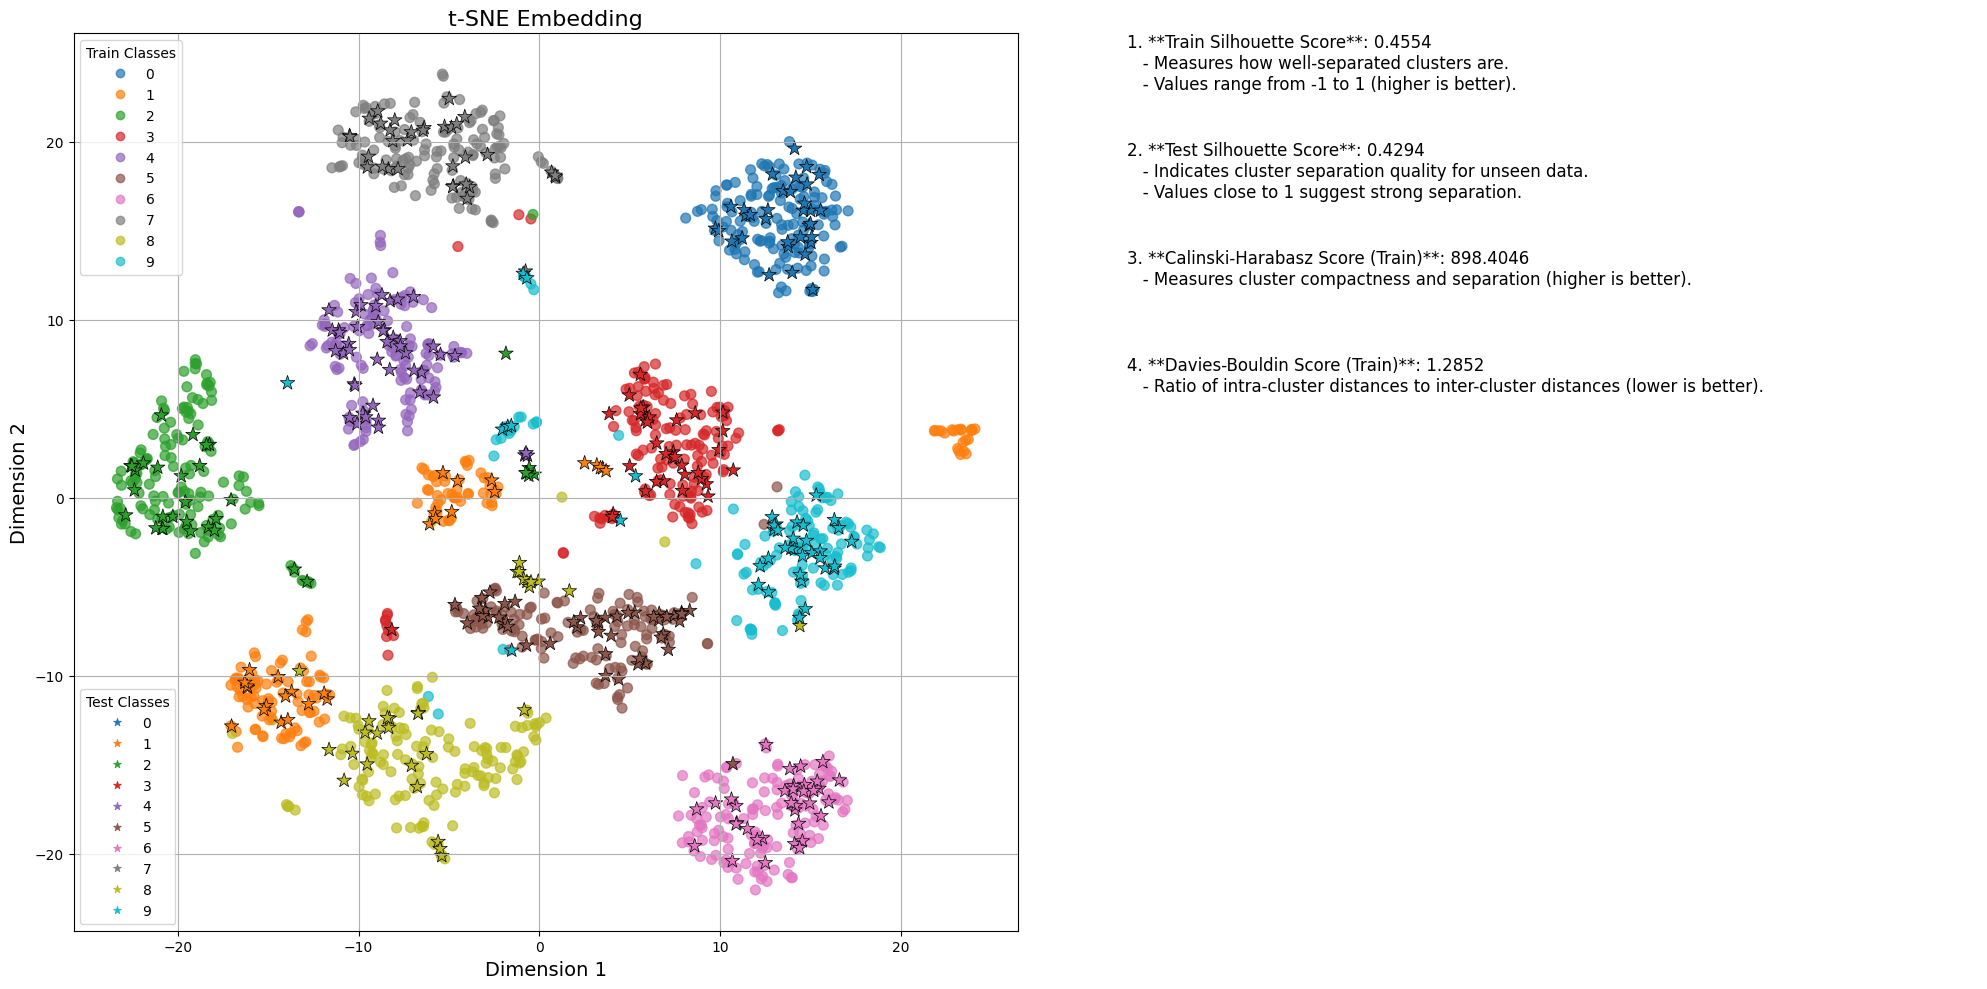

In [ ]:
# Call the enhanced visualization function
metrics = enhanced_tsne_visualization(custom_Y, custom_Y_new, y_train, y_test)

# Use of generative AI
1. Help with english grammer
2. help with jupyter notebook markdown cell design
3. help with the binary search helper class
4. to solve error bugs in the runing - resolve imports, intallations etx
5. help with the graphs plotting and design
6. Formulas of score and optimization (very last section)